Gravity turn gives us the following ODE:

$\begin{align}
\frac{dv}{dt} &= g(n-sin(\gamma)) \\
\frac{d\gamma}{dt} &= -\frac{1}{v}g\cdot cos(\gamma)
\end{align}$

With $n=\frac{a}{g}$


## Numerical solving

Problem with solving this is that if we start with a vertical rocket at $\gamma=90^{\circ}, v=0 \ m/s$, the set of equations obviously simplify to:

$\begin{align}
\frac{dv}{dt} &= gn \\
\frac{d\gamma}{dt} &= -\infty
\end{align}$

Which of course makes no sense. In practicality what this all means is just that if we don't give the rocket an initial kick, it won't start to fall. 
We could always start with slightly perturbed initial conditions and solve numerically, but as it turns out, the ODE is very stiff and this wont do 
a very good job. What will work instead is starting from a known final angle and velocity, and build our way back to $\gamma=90^{\circ}, v=0 \ m/s$.
This is rather simple and only requires reversing the sign of the ODEs:

$\begin{align}
\frac{dv}{dt} &= -g(n-sin(\gamma)) \\
\frac{d\gamma}{dt} &= \frac{1}{v}g\cdot cos(\gamma)
\end{align}$


In [156]:
from scipy.integrate import odeint, trapz, cumtrapz
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
from astropy.constants import g0 #gravitational constant

In [131]:
def simple_gravityturn(y, t, g, n):
    v, gamma = y
    dvdt = -g*(n-np.sin(gamma))
    dgammadt = g*np.cos(gamma)/v
    dydt = [dvdt, dgammadt]
    return dydt

In [181]:
def simple_gravityturn_forwards(y, t, g, n):
    v, gamma = y
    dvdt = g*(n-np.sin(gamma))
    dgammadt = -g*np.cos(gamma)/v
    dydt = [dvdt, dgammadt]
    return dydt

## Constant acceleration

Assuming g=9.81, n=3, $\gamma_{final}=20^{\circ}, v_{final}=1,500m/s$

In [132]:
g = 9.81
n = 3
gfinal = np.deg2rad(20)
vfinal = 1500

We will use one pyhtons ODE solvers: odeint

In [134]:
turnsolver = lambda t : odeint(simple_gravityturn, [vfinal, gfinal], [0,t], args=(g,n))[1,:]

If be backwards solve the original ODEs over 10 seconds we get:

In [135]:
turnsolver(10)

array([  1.24221367e+03,   4.15652097e-01])

As expected, the velocity is going down, and so it the angle. But when do we reach zero? Let's use fsolve:

In [136]:
velocity_only = lambda t: turnsolver(t)[0]
tzero = fsolve(velocity_only, 60)

In [137]:
tzero

array([ 63.8765345])

We can now get the full trajectory:

In [160]:
t = np.linspace(0, tzero, 1000)
yout = odeint(simple_gravityturn, [vfinal, gfinal], t, args=(g,n))
v,gamma = yout.transpose()

<IPython.core.display.Javascript object>


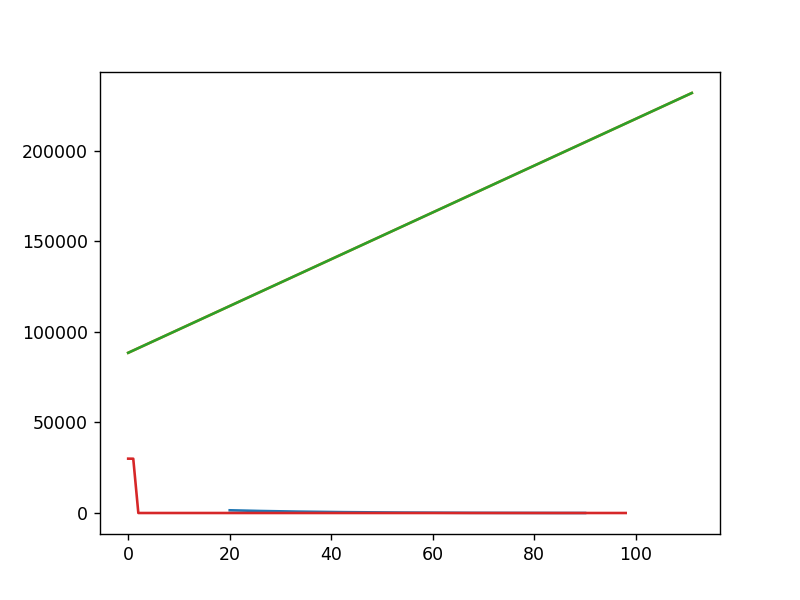

In [167]:
plt.plot(np.rad2deg(gamma), v);

### Gravity losses

Defined as $\int_{0}^{t_f} g\cdot sin(\gamma)$

In [178]:
trapz(g*np.sin(gamma), t)

379.88645079909463

## Delta II

In [281]:
def real_gravityturn(y, t, g, F, mdot):
    v, gamma, m = y
    dvdt = -F/m+g*np.sin(gamma)
    dgammadt = g*np.cos(gamma)/v
    dmdt = mdot
    dydt = [dvdt, dgammadt, dmdt]
    return dydt

In [282]:
62.28*8896.4432+50.2*8896.4432*6

3233679.174336

In [283]:
50.2*8896.4432

446601.44864

In [284]:
50*8896.4432

444822.16

In [285]:
446.02*6+890

3566.12

In [286]:
F = 3110e3 #N
Fsolid = 446e3*6
Fliq = F-Fsolid
Isp_solid = 245.4
Isp_liq = 273
mtotal = 231870 #kg

csolid = Isp_solid*g
cliq = Isp_liq*g
mdot = Fsolid/csolid+Fliq/cliq

mfuelsolidbooster = 11765
mfinal_guess = mtotal - 9*mfuelsolidbooster

In [287]:
F/mtotal

13.412688144218743

In [288]:
realturnsolver = lambda mf, t : odeint(real_gravityturn, [vfinal, gfinal, mf], [0,t], args=(g,F,mdot))[1,:]

In [289]:
velocity_only = lambda x: realturnsolver(x[0], x[1])[[0,2]] - np.array([0, mtotal])
tzero = fsolve(velocity_only, np.array([mfinal_guess, 60]))

In [290]:
tzero

array([ 89393.97211791,    111.86540023])

In [291]:
realturnsolver(tzero[0], tzero[1])

array([  2.74594236e-12,   1.57079633e+00,   2.31870000e+05])

In [292]:
t = np.linspace(0, tzero[1], 1000)
yout = odeint(real_gravityturn, [vfinal, gfinal, tzero[0]], t, args=(g,F,mdot))
v,gamma,mass = yout.transpose()

In [255]:
trapz(g*np.sin(gamma), t)

827.3600887742632

## Drag

In [368]:
R = 287
T = 290
H = R*T/g
rho0 = 1.225
CD = 2
D = 2.896
A = np.pi*(D/2)**2

In [369]:
def drag_gravityturn(y, t, g, F, mdot):
    v, gamma, m, z = y
    rho = rho0*np.exp(-z/H)
    dvdt = -F/m+g*np.sin(gamma)+0.5*CD*A*rho*v**2/m
    dgammadt = g*np.cos(gamma)/v
    dmdt = mdot
    dzdt = -v*np.sin(gamma)
    dydt = [dvdt, dgammadt, dmdt, dzdt]
    return dydt

In [370]:
dragsolver = lambda mf, t, z: odeint(drag_gravityturn, [vfinal, gfinal, mf, z], [0,t], args=(g,F,mdot))[1,:]

In [371]:
velocity_only = lambda x: dragsolver(x[0], x[1], x[2])[[0,2,3]] - np.array([0, mtotal, 0])
tzero = fsolve(velocity_only, np.array([mfinal_guess, 50, zfinal]))

In [372]:
tzero

array([ 77128.68992952,    121.4955164 ,  34462.43711166])

In [373]:
t = np.linspace(0, tzero[1], 100)
yout = odeint(drag_gravityturn, [vfinal, gfinal, tzero[0], tzero[2]], t, args=(g,F,mdot))
v,gamma,mass,z = yout.transpose()

In [374]:
rho = rho0*np.exp(-z/H)

In [375]:
trapz(0.5*CD*A*rho*v**2/mass, t)

271.28091968228779